In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("raddar/chest-xrays-indiana-university")

print("Path to dataset files:", path)

C:\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\ANNU-10\.cache\kagglehub\datasets\raddar\chest-xrays-indiana-university\versions\2


In [2]:
import pandas
import numpy
import torch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.__version__)

Using device: cuda
2.7.1+cu128


In [4]:
dataset_folder = path
images_folder = dataset_folder + "/images/images_normalized"
projections = pandas.read_csv(dataset_folder + "/indiana_projections.csv")
reports = pandas.read_csv(dataset_folder + "/indiana_reports.csv")
projections.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [5]:
import torchvision.models as models
from torch import nn

class VisionEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        backbone = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(backbone.children())[:-2])
        self.fc = nn.Linear(2048, embed_dim)

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        return self.fc(x)

In [6]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

def generate_report(image_features, prompt="Findings:"):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    image_embeds = image_features.unsqueeze(1)
    outputs = model.generate(input_ids=input_ids, max_length=256)
    return tokenizer.decode(outputs[0])

In [7]:
def generate_report2(image_features=None, prompt="Findings:"):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    # image_embeds = image_features.unsqueeze(1)
    outputs = model.generate(input_ids=input_ids, max_length=256)
    return tokenizer.decode(outputs[0])

generate_report2()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


'Findings:\n\nThe study found that the average age of women who had been diagnosed with breast cancer was 26.5 years.\n\nThe study also found that the average age of women who had been diagnosed with breast cancer was 26.5 years.\n\nThe study also found that the average age of women who had been diagnosed with breast cancer was 26.5 years.\n\nThe study also found that the average age of women who had been diagnosed with breast cancer was 26.5 years.\n\nThe study also found that the average age of women who had been diagnosed with breast cancer was 26.5 years.\n\nThe study also found that the average age of women who had been diagnosed with breast cancer was 26.5 years.\n\nThe study also found that the average age of women who had been diagnosed with breast cancer was 26.5 years.\n\nThe study also found that the average age of women who had been diagnosed with breast cancer was 26.5 years.\n\nThe study also found that the average age of women who had been diagnosed with breast cancer wa

In [8]:
import cv2
import matplotlib.pyplot as pyplot

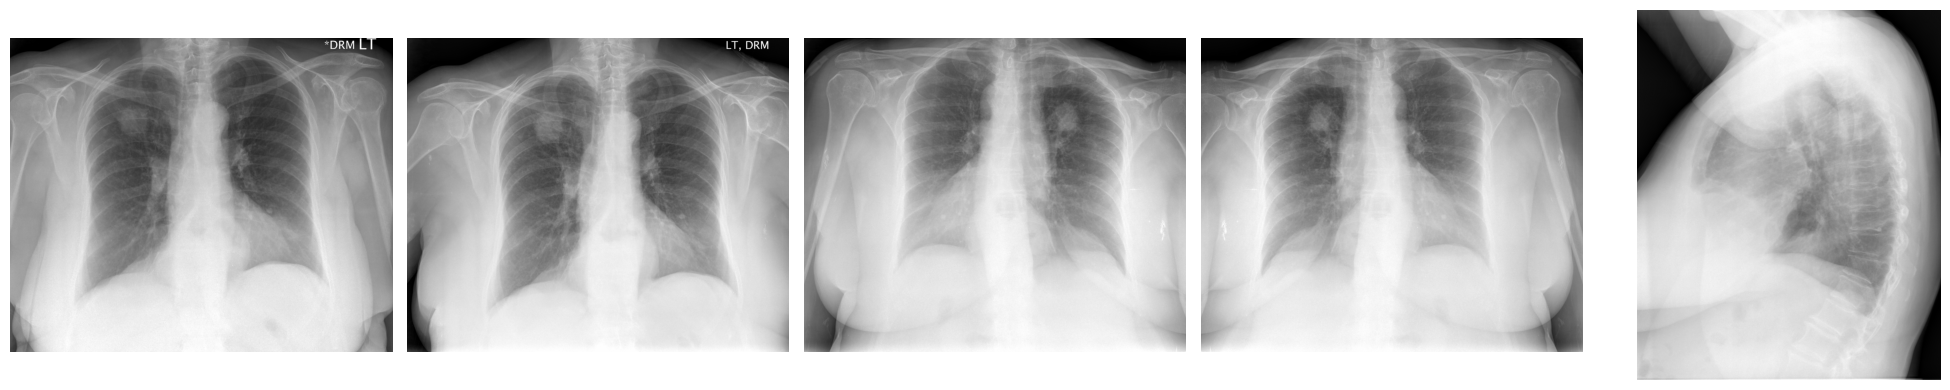

In [9]:
fig, axes = pyplot.subplots(1, 5, figsize=(20, 4))

imgs_by_uid = projections.loc[projections["uid"] == 1303, "filename"].map(lambda x: images_folder + "/" + x)
for ax, img_path in zip(axes, imgs_by_uid):
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if len(img.shape) == 3 and img.shape[2] == 3:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        ax.imshow(img, cmap="gray")
    ax.axis("off")
    # ax.set_title(fname)

pyplot.tight_layout()
pyplot.show()

In [10]:
projections.merge(reports, on="uid", how="inner").head()

,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
3,2,2_IM-0652-2001.dcm.png,Lateral,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
4,3,3_IM-1384-1001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."


In [11]:
projections["projection"].value_counts()

projection
Frontal    3818
Lateral    3648
Name: count, dtype: int64

In [12]:
projections["uid"].value_counts()

uid
1303    5
3965    4
1102    4
3932    4
1525    4
       ..
3306    1
3303    1
3323    1
3316    1
3333    1
Name: count, Length: 3851, dtype: int64

In [13]:
combined_dataset = projections.merge(reports, on="uid", how="inner")
combined_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7466 entries, 0 to 7465
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uid         7466 non-null   int64 
 1   filename    7466 non-null   object
 2   projection  7466 non-null   object
 3   MeSH        7466 non-null   object
 4   Problems    7466 non-null   object
 5   image       7466 non-null   object
 6   indication  7307 non-null   object
 7   comparison  5206 non-null   object
 8   findings    6469 non-null   object
 9   impression  7414 non-null   object
dtypes: int64(1), object(9)
memory usage: 583.4+ KB


In [14]:
def IsNotAvailable(value):
    return value.str.contains("unavailable", case=False, na=False) \
        | value.str.contains("not available", case=False, na=False) \
        | value.str.contains("none", case=False, na=False)

combined_dataset.loc[IsNotAvailable(combined_dataset["comparison"]), "comparison"] = "None"

In [15]:
combined_dataset["comparison"].value_counts()

comparison
None                                               2121
XXXX                                                539
XXXX, XXXX.                                         417
XXXX, XXXX                                          306
XXXX.                                               231
                                                   ... 
Two view chest XXXX.                                  1
Yesterday.                                            1
chest XXXX, XXXX.                                     1
PA and lateral chest x-XXXX dated XXXX                1
Two-view chest rehabilitation dated XXXX, XXXX.       1
Name: count, Length: 367, dtype: int64

In [16]:
combined_dataset["indication"] = combined_dataset["indication"].fillna("None")
combined_dataset["findings"] = combined_dataset["findings"].fillna("None")
combined_dataset["impression"] = combined_dataset["impression"].fillna("None")
combined_dataset["comparison"] = combined_dataset["comparison"].fillna("None")

combined_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7466 entries, 0 to 7465
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uid         7466 non-null   int64 
 1   filename    7466 non-null   object
 2   projection  7466 non-null   object
 3   MeSH        7466 non-null   object
 4   Problems    7466 non-null   object
 5   image       7466 non-null   object
 6   indication  7466 non-null   object
 7   comparison  7466 non-null   object
 8   findings    7466 non-null   object
 9   impression  7466 non-null   object
dtypes: int64(1), object(9)
memory usage: 583.4+ KB


In [17]:
combined_dataset.head()

,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,Positive TB test,None,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
3,2,2_IM-0652-2001.dcm.png,Lateral,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
4,3,3_IM-1384-1001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",None,None,"No displaced rib fractures, pneumothorax, or p..."


In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(combined_dataset, test_size=0.2, random_state=42, shuffle=True)
print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 5972, Test size: 1494


In [ ]:
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Define a dataset for loading images from combined_dataset
class XrayImageDataset(Dataset):
    def __init__(self, dataframe, images_folder, transform=None):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]["filename"]
        img_path = os.path.join(self.images_folder, img_name)
        image = Image.open(img_path)
        if image.mode != "RGB":
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_name

# Use ViT weights and transforms
weights = ViT_B_16_Weights.DEFAULT
vit_model = vit_b_16(weights=weights, progress=True).to(device)
vit_model.eval()
transform = weights.transforms()

# Create dataset and dataloader
xray_dataset = XrayImageDataset(combined_dataset, images_folder, transform=transform)
dataloader = DataLoader(xray_dataset, batch_size=16, shuffle=False)

# Extract features
features_dict = {}
with torch.no_grad():
    for images, img_names in dataloader:
        images = images.to(device)
        output = vit_model(images)  # shape: (batch, num_classes) if head is present, else features
        # To get the CLS token features, use vit_model._process_input and vit_model.encoder
        x = vit_model._process_input(images)
        n = x.shape[0]
        batch_class_token = vit_model.class_token.expand(n, -1, -1)
        x = torch.cat((batch_class_token, x), dim=1)
        x = vit_model.encoder(x)
        cls_feats = x[:, 0, :]  # CLS token
        for name, feat in zip(img_names, cls_feats.cpu()):
            features_dict[name] = feat.numpy()

features_dict

In [21]:
import csv

with open("vit_extracted_features.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    # Write header: first column is image name, rest are feature indices
    feature_dim = next(iter(features_dict.values())).shape[0]
    header = ["filename"] + [f"feat_{i}" for i in range(feature_dim)]
    writer.writerow(header)
    for name, feat in features_dict.items():
        writer.writerow([name] + feat.tolist())

In [ ]:
features_df = pandas.read_csv("vit_extracted_features.csv")
features_dict_cached = {
    row["filename"]: row.iloc[1:].to_numpy(dtype=float)
    for _, row in features_df.iterrows()
}

features_dict_cached

In [29]:
from transformers import GPT2Config, GPT2LMHeadModel, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch

class XrayReportDataset(Dataset):
    def __init__(self, dataframe, features_dict, tokenizer, max_length=256):
        self.dataframe = dataframe.reset_index(drop=True)
        self.features_dict = features_dict
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row["findings"] if isinstance(row["findings"], str) else "None"
        img_name = row["filename"]
        input_ids = self.tokenizer(
            text, truncation=True, max_length=self.max_length, return_tensors="pt"
        ).input_ids.squeeze(0)
        image_features = torch.tensor(self.features_dict[img_name], dtype=torch.float32)
        return {
            "input_ids": input_ids,
            "labels": input_ids,
            "image_features": image_features
        }

# Prepare dataset
train_dataset = XrayReportDataset(train, features_dict, tokenizer)
eval_dataset = XrayReportDataset(test, features_dict, tokenizer)

# Custom data collator to pad sequences and batch image features
def data_collator(batch):
    input_ids = [item["input_ids"] for item in batch]
    labels = [item["labels"] for item in batch]
    image_features = torch.stack([item["image_features"] for item in batch])
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)
    # Expand image_features for cross-attention: (batch, seq_len, feat_dim)
    image_features_expanded = image_features.unsqueeze(1).repeat(1, input_ids.shape[1], 1)
    return {
        "input_ids": input_ids,
        "labels": labels,
        "cross_attn_hidden_states": image_features_expanded
    }

# Prepare GPT-2 with cross-attention
gpt2_cross_config = GPT2Config.from_pretrained("gpt2", add_cross_attention=True)
gpt2_cross = GPT2LMHeadModel(gpt2_cross_config).to(device)
gpt2_cross.load_state_dict(model.state_dict(), strict=False)

# Custom Trainer to pass cross_attn_hidden_states
class XrayTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        cross_attn_hidden_states = inputs.pop("cross_attn_hidden_states")
        outputs = model(
            input_ids=inputs["input_ids"].to(device),
            labels=inputs["labels"].to(device),
            cross_attn_hidden_states=cross_attn_hidden_states.to(device)
        )
        loss = outputs.loss
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="./gpt2_xray",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    eval_strategy="steps",
    eval_steps=100,
    save_steps=200,
    logging_steps=50,
    learning_rate=5e-5,
    report_to="none"
)

trainer = XrayTrainer(
    model=gpt2_cross,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer
)

trainer.train()

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`